In [1]:
import word2vec as w2v
import pandas as pd
# import cupy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras
import re

import warnings
warnings.filterwarnings("ignore")
# tf.debugging.set_log_device_placement(True)
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-06-13 18:31:29.014809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 18:31:32.921429: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-06-13 18:31:32.921661: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-06-13 18:31:32.924571: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-06-13 18:31:33.326321: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


2.10.0
Num GPUs Available:  1


In [2]:
size = 43352
vec_size = 100
trumpTweets_DF = pd.read_csv("realdonaldtrump.csv", sep=",")
# model = w2v.Word2Vec() #tweetsContent[:1000], 100, 3, 2, cpu_count=16
# model.loadFromFile("./models/model_"+str(size)+".txt")

In [3]:
result_data = w2v.Word2Vec()
result_data.loadFromFile("./models/calculated_model_" + str(size) + "_" + str(vec_size) + ".txt")
result = result_data.words_df
# print(1- cosine(model.words_df.loc[result["word"].isin(["donald"])]["vector"].values[0], model.words_df.loc[result["word"].isin(["trump"])]["vector"].values[0]))
# print(1- cosine(result.loc[result["word"].isin(["donald"])]["vector"].values[0], result.loc[result["word"].isin(["trump"])]["vector"].values[0]))

In [4]:
def R2(y_true, y_pred) :
	sum_squares_residuals = ((y_true - y_pred) ** 2).sum()
	sum_squares = ((y_true - y_true.mean()) ** 2).sum()
	R2 = 1 - sum_squares_residuals / sum_squares
	return R2

In [5]:
def FilterDataset(dataset) :
	filtered = dataset.copy()
	for text, idx in zip(filtered.content.values, filtered.index.values) :
		tmp = np.array([word for word in re.sub('\W', ' ', re.sub("[’']", "", re.sub("http[\S]+", "URL", text, flags=re.U), flags=re.U), flags=re.U).lower().split()])
		if len(tmp) <= 1 :
			filtered.loc[idx]
			filtered = filtered.drop(idx)
	return filtered

filtered_df = FilterDataset(trumpTweets_DF)


In [6]:
print(trumpTweets_DF.shape)
print(filtered_df.shape, len(w2v.stripPunctuation(trumpTweets_DF.content)))

(43352, 8)
(43228, 8) 43228


In [7]:
list_of_tweets = w2v.stripPunctuation(filtered_df.content[:size])
filtered_df["content_vectors"] = [np.vstack(result.loc[result.word.isin(tweet)].vector.values) for tweet in list_of_tweets]
longest_tweet = 0
for tweet in filtered_df["content_vectors"] :
	if tweet.shape[0] > longest_tweet :
		longest_tweet = tweet.shape[0]

In [8]:
filtered_df["content_vectors"][3338:3341]

3338    [[-0.13344245, -0.09807289, 0.12608806, -0.006...
3340    [[-0.11111873, 0.10290364, 0.10570455, 0.15378...
3341    [[0.100116366, -0.0961423333, -0.169584203, 0....
Name: content_vectors, dtype: object

In [9]:
for i, tweet in zip(filtered_df.index, filtered_df["content_vectors"]) :
	filtered_df["content_vectors"][i] = np.pad(tweet, [(0, longest_tweet - tweet.shape[0]), (0,0)])
list_of_tweets_as_vec = np.stack(filtered_df["content_vectors"])

n_sampl, n_x, n_y = list_of_tweets_as_vec.shape
d2_list_of_tweets = list_of_tweets_as_vec.reshape((n_sampl,n_x*n_y))

In [10]:
wordX_train, wordX_test, wordy_train, wordy_test = train_test_split(list_of_tweets_as_vec, filtered_df.retweets[:size], test_size=0.2, random_state=3423534) #

In [11]:
retweets_model = keras.Sequential()
retweets_model.add(keras.Input(shape=list_of_tweets_as_vec.shape[1:]))
retweets_model.add(keras.layers.Flatten())
retweets_model.add(keras.layers.Dense(100, activation="linear"))
retweets_model.add(keras.layers.Dense(85, activation="linear"))
retweets_model.add(keras.layers.Dense(70, activation="linear"))
retweets_model.add(keras.layers.Dense(55, activation="linear"))
retweets_model.add(keras.layers.Dense(40, activation="linear"))
retweets_model.add(keras.layers.Dense(25, activation="linear"))
retweets_model.add(keras.layers.Dense(10, activation="linear"))
retweets_model.add(keras.layers.Dense(25, activation="linear"))
retweets_model.add(keras.layers.Dense(1, activation="linear"))
retweets_model.compile(loss="mae", optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=['mae', 'mse', 'msle', 'poisson'])

2024-06-13 18:34:33.828655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 18:34:33.836247: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3060 Laptop GPU)
2024-06-13 18:34:36.575884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 18:34:36.576615: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2024-06-13 18:34:36.576939: I tensorflow/core/common_runtime/pluggable_device/pluggab

: 

In [12]:
with tf.device('/GPU:0') :
	history = retweets_model.fit(wordX_train, wordy_train, validation_split=0.2, verbose=1, epochs=1000)

2024-06-13 18:34:41.862737: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 564366000 exceeds 10% of free system memory.
2024-06-13 18:34:47.123410: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 564366000 exceeds 10% of free system memory.


Epoch 1/1000


2024-06-13 18:34:49.919203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-13 18:34:50.055978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 18:34:50.056076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


865/865 [==============================] - ETA: 0s - loss: 4474.5200 - mae: 4474.5200 - mse: 101099568.0000 - msle: 8.3941 - poisson: nan

2024-06-13 18:35:08.619740: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 141106800 exceeds 10% of free system memory.
2024-06-13 18:35:08.713740: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 141106800 exceeds 10% of free system memory.
2024-06-13 18:35:09.088813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-13 18:35:09.141368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 18:35:09.141459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


865/865 [==============================] - 22s 19ms/step - loss: 4474.5200 - mae: 4474.5200 - mse: 101099568.0000 - msle: 8.3941 - poisson: nan - val_loss: 4460.6226 - val_mae: 4460.6226 - val_mse: 91490488.0000 - val_msle: 6.1265 - val_poisson: nan
Epoch 2/1000
865/865 [==============================] - 14s 16ms/step - loss: 4272.6694 - mae: 4272.6694 - mse: 94184872.0000 - msle: 7.9525 - poisson: nan - val_loss: 4295.0020 - val_mae: 4295.0020 - val_mse: 87419264.0000 - val_msle: 7.2897 - val_poisson: nan
Epoch 3/1000
865/865 [==============================] - 14s 16ms/step - loss: 4183.4746 - mae: 4183.4746 - mse: 91476736.0000 - msle: 7.8488 - poisson: nan - val_loss: 4321.3989 - val_mae: 4321.3989 - val_mse: 88311144.0000 - val_msle: 7.5725 - val_poisson: nan
Epoch 4/1000
865/865 [==============================] - 14s 16ms/step - loss: 4192.9331 - mae: 4192.9331 - mse: 90970576.0000 - msle: 8.1075 - poisson: nan - val_loss: 4393.7632 - val_mae: 4393.7632 - val_mse: 83752592.0000 - 

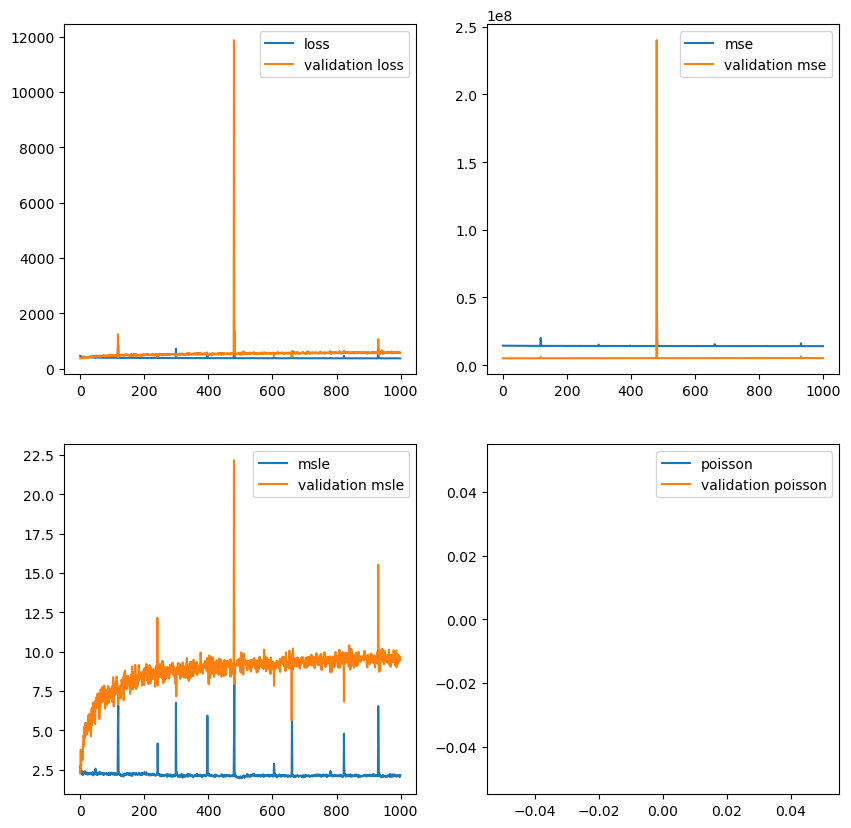

In [ ]:
plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.subplot(2,2,2)
plt.plot(history.history['mse'], label = 'mse')
plt.plot(history.history['val_mse'], label = 'validation mse')
plt.legend()
plt.subplot(2,2,3)
plt.plot(history.history['msle'], label = 'msle')
plt.plot(history.history['val_msle'], label = 'validation msle')
plt.legend()
plt.subplot(2,2,4)
plt.plot(history.history['poisson'], label = 'poisson')
plt.plot(history.history['val_poisson'], label = 'validation poisson')
plt.legend()
plt.show()


 34/125 [=======>......................] - ETA: 0s

2024-06-13 17:26:42.309350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 1s 4ms/step


2024-06-13 17:26:42.856449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 17:26:42.856522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-13 17:26:42.932979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 17:26:42.933097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: 

16/32 [==============>...............] - ETA: 0s

2024-06-13 17:26:43.168494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2024-06-13 17:26:43.521517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 17:26:43.521610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


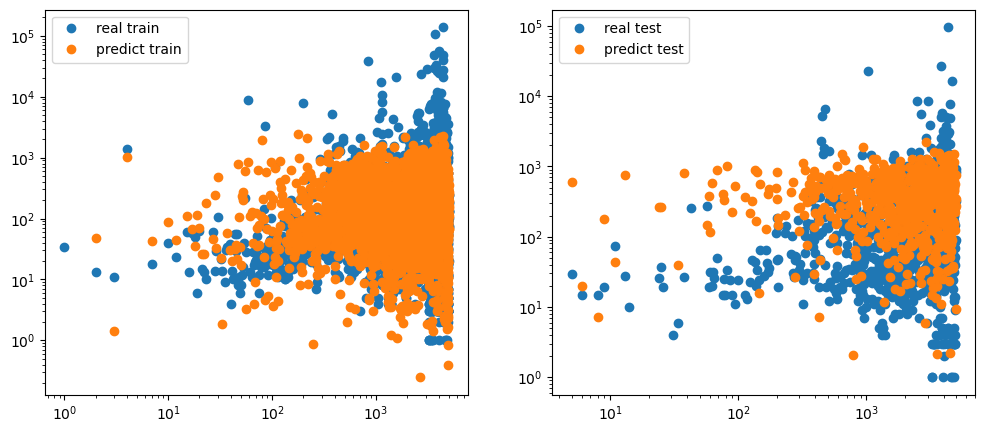

In [ ]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.xscale('log')
plt.yscale('log')
plt.plot(wordy_train.index, wordy_train.values, 'o', label="real train")
plt.plot(wordy_train.index, retweets_model.predict(wordX_train), 'o', label="predict train")
plt.legend()
plt.subplot(1,2,2)
plt.xscale('log')
plt.yscale('log')
plt.plot(wordy_test.index, wordy_test, 'o', label="real test")
plt.plot(wordy_test.index, retweets_model.predict(wordX_test), 'o', label="predict test")
plt.legend()


In [ ]:
#print(retweets_model.summary())
#score = retweets_model.evaluate(wordX_train, retweet_y_train)

# metric = keras.metrics.CosineSimilarity()
R2_train = R2(wordy_train.values.reshape(-1,1), retweets_model.predict(wordX_train))
print("Score train:", R2_train)
# metric = keras.metrics.CosineSimilarity()
R2_test = R2(wordy_test.values.reshape(-1,1), retweets_model.predict(wordX_test))
print("Score test:", R2_test)


125/125 [==============================] - 1s 4ms/step
Score train: 0.011916568599906974
32/32 [==============================] - 0s 3ms/step
Score test: -0.014720713060662138


In [ ]:
pred_test = retweets_model.predict(wordX_test)
for i in range(wordy_test.shape[0]) :
  print(wordy_test.values[i], pred_test[i])

32/32 [==============================] - 0s 3ms/step
28 [714.6159]
24 [954.821]
82 [196.15996]
17 [-558.1523]
354 [-181.9646]
15 [-81.176346]
109 [-185.40271]
46 [345.4537]
13 [-813.76355]
289 [-369.18484]
234 [111.11009]
462 [959.02527]
216 [1265.5549]
137 [-167.77803]
30 [397.4382]
29 [-424.40158]
11 [316.83704]
52 [-148.801]
80 [-43.34048]
43 [508.4958]
164 [-43.731358]
37 [683.12775]
117 [190.74026]
61 [153.8409]
3 [253.29088]
15 [225.19757]
322 [270.801]
27 [1119.1129]
439 [48.461773]
789 [-218.87839]
43 [203.3049]
672 [406.88455]
266 [-130.84297]
3 [-168.42207]
100 [845.1496]
56 [-207.73537]
5 [99.35676]
372 [135.49182]
323 [78.827576]
15 [365.32547]
508 [637.74414]
50 [-23.016891]
111 [242.13226]
140 [-309.635]
150 [512.06396]
346 [271.84198]
89 [139.42583]
60 [231.85533]
29 [201.53284]
18 [248.63013]
89 [227.09856]
179 [794.28156]
802 [157.00665]
238 [-112.49123]
1803 [262.34314]
484 [341.70413]
44 [885.8718]
720 [650.92865]
620 [31.634855]
30 [76.10536]
4 [199.27191]
17 [147.7